<b><font size=5><center>Выявление профилей потребления.<br>
    </center></font></b>

# Шаг 1. Загрузка данных

In [1]:
# Подключим необходимые для работы библиотеки
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram, linkage  
from sklearn.cluster import KMeans
import itertools

import scipy.stats as st

# pip install pymorphy2
import pymorphy2

pd.options.display.max_colwidth = 150


In [2]:
# Загрузим данные, выведем первые 5 строк датафрейма и посмотрим общую информацию
data = pd.read_csv('/datasets/ecommerce_dataset.csv')
display(data.head())
data.info()

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


**Вывод:**
- пропуски в датасете не выявлены, оброботка нулевых значений на этапе предобработки данных не требуется;
- в столбце `date` цельночисловой тип данных, необходимо привести столбец с датой к типу datetime.

# Шаг 2. Предобработка данных

- приведение столбцов к нужным типам данных
- поиск и обработка дубликтов (явных и скрытых)

In [3]:
# Приведем столбец с датой к типу datetime
data['date'] = pd.to_datetime(data['date'], format='%Y%m%d%H', errors='coerce')
display(data.head(50))
data.dtypes

,date,customer_id,order_id,product,quantity,price
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0
2,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0
5,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Шеффлера Лузеана d-9 см,1,164.0
6,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Юкка нитчатая d-12 см h-25-35 см,1,134.0
7,2018-10-01 08:00:00,375e0724-f033-4c76-b579-84969cf38ee2,68479,Настенная сушилка для белья Gimi Brio Super 100,1,824.0
8,2018-10-01 08:00:00,6644e5b4-9934-4863-9778-aaa125207701,68478,"Таз пластмассовый 21,0 л круглый ""Водолей"" С614, 1404056",1,269.0
9,2018-10-01 09:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68480,Чехол для гладильной доски Colombo Persia Beige 130х50 см из хлопка 5379,1,674.0


date           datetime64[ns]
customer_id            object
order_id                int64
product                object
quantity                int64
price                 float64
dtype: object

**Проверим датасет на наличие явных дубликатов**

In [4]:
data.duplicated().sum()

0

**Проверим датасет не наличие неявных дубликатов**

In [5]:
# Узнаем количество уникальных пользователей
data['customer_id'].nunique()

2451

In [6]:
# Узнаем количество уникальных заказов
data['order_id'].nunique()

2784

In [7]:
# Узнаем количество проведенных транзакций
transaction = data.groupby('date').agg({'order_id':'nunique'})
transaction['order_id'].sum()

3418

**Первая улика - количество заказов не совпадает с количеством транзакций. По логике 1 заказ - 1 транзакция. Посмотрим на количество транзакций по каждому заказу, также проверим, чтобы 1 уникальный заказ был оформлен на 1 уникального пользователя**

In [8]:
orders = (
    data
    .groupby('order_id')
    .agg({'date':'nunique','customer_id':'nunique'})
    .rename(columns={'date':'transaction'})
    .sort_values(by='transaction', ascending=False)
    .reset_index()
)
orders.head(15)

,order_id,transaction,customer_id
0,14833,74,1
1,70960,60,1
2,69162,23,1
3,71148,16,1
4,69531,12,2
5,70419,10,1
6,71463,9,1
7,69527,9,1
8,70962,8,1
9,70620,7,1


**Вот они - заказы, по которым было проведено несколько транзакций. Также обнаружили, что один номер заказа был присвоен разным покупателям. Изучим более детально содержание аномальных заказов**

In [9]:
order_74 = data.loc[data['order_id'] == 14833]
order_74.groupby('date').agg({'product':'nunique', 'price':'sum'})

,product,price
date,,
2019-05-31 12:00:00,12,1530.0
2019-05-31 16:00:00,12,1530.0
2019-06-01 07:00:00,12,1530.0
2019-06-01 20:00:00,12,1530.0
2019-06-01 22:00:00,12,1530.0
...,...,...
2019-06-18 18:00:00,12,1530.0
2019-06-19 00:00:00,12,1530.0
2019-06-21 11:00:00,12,1530.0


**Так например, заказ №14833 с 12 наименованиями товаров на общую сумму 1530 попал в датасет аж 74 раза под разными датами. Посмотрим, что в самом заказе**

In [10]:
order_74.head(24)

,date,customer_id,order_id,product,quantity,price
4157,2019-05-31 12:00:00,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,"Рассада Кабачка сорт Аэронавт, кассета по 6шт",1,120.0
4158,2019-05-31 12:00:00,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,Рассада Кабачка сорт Белогор кассета 6 шт E6,1,120.0
4159,2019-05-31 12:00:00,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,"Рассада Кабачка сорт Горный, кассета по 6шт",1,120.0
4160,2019-05-31 12:00:00,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,Рассада Кабачка сорт Зебра кассета 6 шт E6,1,120.0
4161,2019-05-31 12:00:00,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,Рассада Кабачка сорт Золотинка кассета 6 шт E6,1,120.0
4162,2019-05-31 12:00:00,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,"Рассада Кабачка сорт Сосновский, кассета по 6шт",1,120.0
4163,2019-05-31 12:00:00,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,Рассада Огурец Кристина ячейки по 6 шт Е6,1,120.0
4164,2019-05-31 12:00:00,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,Рассада Огурец Фараон ячейки по 6 шт Е6,1,120.0
4165,2019-05-31 12:00:00,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,Рассада Огурца сорт Каролина кассета 6 шт E6,1,120.0
4166,2019-05-31 12:00:00,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,"Рассада Патиссона сорт Диск, кассета по 6шт",1,120.0


**Как и следовало ожидать, абсолютно идентичные заказы, только дата отличается. Скорее всего, произошел какой-то технический сбой и некоторые заказы задублировались под разной датой. Поэтому на этапе поиска явных дубликатов мы их не обнаружили.**

In [11]:
# Узнаем количество заказов, по которым было проведено несколько транзакций
orders.query('transaction != 1').shape

(284, 3)

**Также в датасете присутствуют заказы с одним номером, которые были оформлены разными пользователями. Изучим такой заказ**

In [12]:
data.query('order_id == 69531')

,date,customer_id,order_id,product,quantity,price
1323,2018-12-23 14:00:00,e382d4c4-a4c9-44d3-97a0-a8868e122563,69531,Сумка-тележка хозяйственная Rolser BAB010 rojo JOY-1800 красная,1,4139.0
1338,2018-12-24 08:00:00,e382d4c4-a4c9-44d3-97a0-a8868e122563,69531,Сумка-тележка хозяйственная Rolser BAB010 rojo JOY-1800 красная,1,4139.0
1417,2018-12-28 23:00:00,e382d4c4-a4c9-44d3-97a0-a8868e122563,69531,Сумка-тележка хозяйственная Rolser BAB010 rojo JOY-1800 красная,1,4139.0
1422,2019-01-01 10:00:00,e382d4c4-a4c9-44d3-97a0-a8868e122563,69531,Сумка-тележка хозяйственная Rolser BAB010 rojo JOY-1800 красная,1,4139.0
1429,2019-01-03 08:00:00,e382d4c4-a4c9-44d3-97a0-a8868e122563,69531,Сумка-тележка хозяйственная Rolser BAB010 rojo JOY-1800 красная,1,4139.0
1438,2019-01-05 09:00:00,e382d4c4-a4c9-44d3-97a0-a8868e122563,69531,Сумка-тележка хозяйственная Rolser BAB010 rojo JOY-1800 красная,1,4139.0
1443,2019-01-06 08:00:00,e382d4c4-a4c9-44d3-97a0-a8868e122563,69531,Сумка-тележка хозяйственная Rolser BAB010 rojo JOY-1800 красная,1,4139.0
1449,2019-01-07 09:00:00,2273b174-e223-415a-9be1-49d19abea06e,69531,Сумка-тележка хозяйственная Rolser BAB010 rojo JOY-1800 красная,1,4139.0
2123,2019-03-02 14:00:00,2273b174-e223-415a-9be1-49d19abea06e,69531,Сумка-тележка хозяйственная Rolser BAB010 rojo JOY-1800 красная,1,4139.0
2174,2019-03-04 16:00:00,2273b174-e223-415a-9be1-49d19abea06e,69531,Сумка-тележка хозяйственная Rolser BAB010 rojo JOY-1800 красная,1,4139.0


**Один и тоже же заказ оформлен в разные даты на два разных id покупателя. Если предположить, что товар действительно был куплен разными пользователями, то возникает вопрос, почему был присвоен тот же номер заказа. Скорее всего, это также какой-то технический сбой, возможно, связанный с выгрузкой данных (нужно общаться с специалистом, который занимается выгрузкой данных и искать причины). Будем считать и такие заказы дубликатами**

In [13]:
# Узнаем количество пользователей, которые оформили заказ с одним номером
orders.query('customer_id != 1').shape

(29, 3)

In [14]:
# Узнаем количество заказов, по которым было проведено больше 1 транзакции и у которых больше одного id покупателя
orders.query('transaction != 1 or customer_id != 1').shape

(285, 3)

**Таким образом, в датасете оказалось 285 заказов - дубликатов, от которых необходимо будет избавиться, чтобы они не исказили результаты исследования**

*Еще в датасет попали заказы-дубликаты от одного пользователя, которые отличаются временем и количеством наименований в заказе. Предлагается также убрать их из набора данных* 

In [15]:
data.loc[data['order_id'] == 69282]

,date,customer_id,order_id,product,quantity,price
1152,2018-12-10 11:00:00,bbb32131-2d92-4c1e-aa28-41723f7bc26c,69282,Кружка прозрачная 250 мл H8437 Luminarc Франция,6,44.0
1218,2018-12-16 10:00:00,bbb32131-2d92-4c1e-aa28-41723f7bc26c,69282,Кружка прозрачная 250 мл H8437 Luminarc Франция,6,44.0
1232,2018-12-17 10:00:00,bbb32131-2d92-4c1e-aa28-41723f7bc26c,69282,Кружка прозрачная 250 мл H8437 Luminarc Франция,12,44.0


**На основании изложенного предлагается принять за уникальные строки те, где 1 номеру заказа соответсвует 1 наименование товара. Таким образом мы исключаем возможность попадания дублирующих заказов в датасет. Посмотрим, сколько строк-дубликатов в наборе данных на данный момент**

In [16]:
data.duplicated(subset=['order_id','product']).sum()/len(data)

0.2849933204690515

**28 % дубликатов - это значительное количество данных. Оставить дубликаты не представляется возможным, поскольку они могут исказить итоговый результат исследования, поэтому принимается решение очистить набор данных от дубликатов**

In [17]:
filtred_data = data.drop_duplicates(subset=['order_id','product'], keep='first').reset_index(drop=True)
filtred_data.shape

(4817, 6)

In [18]:
filtred_data.duplicated(subset=['order_id','product']).sum()

0

**В датасете осталось 4817 строк, неявные дубликаты удалены из набора данных. Посмотрим, соответствуют ли данные логике: 1 заказ - 1 покупатель - 1 транзакция** 

In [19]:
filtred_orders = (
    filtred_data
    .groupby('order_id')
    .agg({'date':'nunique','customer_id':'nunique'})
    .rename(columns={'date':'transaction'})
    .sort_values(by='transaction', ascending=False)
    .reset_index()
)
filtred_orders.head(10)

,order_id,transaction,customer_id
0,14898,2,1
1,71143,2,1
2,69485,2,2
3,71426,2,1
4,14649,2,1
5,70186,2,1
6,69750,2,1
7,72517,2,1
8,14500,2,1
9,69527,2,1


In [20]:
filtred_orders.query('transaction != 1 or customer_id != 1').shape

(13, 3)

**Не все заказы соответствуют данной логике, вместе с тем их осталось немного - всего 13 шт(вместо 285). Посмотрим детально на каждый заказ**

In [21]:
filtred_data.query('order_id == 14898')

,date,customer_id,order_id,product,quantity,price
4019,2019-07-09 22:00:00,3ebc0246-48a6-4932-a759-f492c4a7d879,14898,"Рассада зелени для кухни Душица-орегано розовый объем 0,5 л",1,89.0
4020,2019-07-09 22:00:00,3ebc0246-48a6-4932-a759-f492c4a7d879,14898,Рассада зелени для кухни Иссоп лекарственный Аккорд диам. 12-13 см,1,188.0
4021,2019-07-09 22:00:00,3ebc0246-48a6-4932-a759-f492c4a7d879,14898,"Рассада зелени для кухни Петрушка корневая Сахарная, кассета по 6шт",1,128.0
4022,2019-07-09 22:00:00,3ebc0246-48a6-4932-a759-f492c4a7d879,14898,Рассада зелени для кухни Тимьян Сильвер Квин диам. 9 см,1,120.0
4023,2019-07-09 22:00:00,3ebc0246-48a6-4932-a759-f492c4a7d879,14898,Рассада пряной травы Лавр в горшке 9 см,1,45.0
4024,2019-07-09 22:00:00,3ebc0246-48a6-4932-a759-f492c4a7d879,14898,Рассада пряной травы Эвкалипт Сильвердроп в горшке d-9 см,1,52.0
4028,2019-07-10 11:00:00,3ebc0246-48a6-4932-a759-f492c4a7d879,14898,Рассада зелени для кухни Розмарина в горшке диам. 9 см,1,120.0


In [22]:
filtred_data.loc[filtred_data['order_id'] == 69485]

,date,customer_id,order_id,product,quantity,price
1117,2018-12-20 16:00:00,5be0f4b4-947f-4672-b147-73ef5936ecd4,69485,Набор столовых приборов 24 предмета SAINT GERMAIN Domenik DM9638,1,1087.0
1126,2018-12-21 11:00:00,266beb08-ec9b-43b4-89bb-ac60fa23ffee,69485,Набор столовых приборов 24 предмета FARANDOLE Domenik DM9635,1,1274.0


In [23]:
filtred_data.loc[filtred_data['order_id'] == 70995]

,date,customer_id,order_id,product,quantity,price
2225,2019-04-03 17:00:00,cfc1fd9f-ac10-417d-aad8-ce5fcbc4d786,70995,Чехол для гладильной доски Zalger 520133 120х40 см хлопок поролон для доски 115х35 см,1,239.0
2332,2019-04-08 15:00:00,cfc1fd9f-ac10-417d-aad8-ce5fcbc4d786,70995,Настенная сушилка для белья Gimi Brio Super 80,1,749.0


In [24]:
filtred_data.loc[filtred_data['order_id'] == 71143]

,date,customer_id,order_id,product,quantity,price
2421,2019-04-15 07:00:00,1772d490-ef94-4d83-9bb1-9a12aebbe3ce,71143,Муляж Банан желтый 21 см полиуретан,1,59.0
2503,2019-04-18 15:00:00,1772d490-ef94-4d83-9bb1-9a12aebbe3ce,71143,Муляж Апельсин 8 см полиуретан,1,59.0


In [25]:
filtred_data.loc[filtred_data['order_id'] == 14649]

,date,customer_id,order_id,product,quantity,price
2440,2019-04-16 13:00:00,0184f535-b60a-4914-a982-231e3f615206,14649,"Бакопа ампельная махровая сиреневая махровая объем 0,5 л",1,90.0
2441,2019-04-16 13:00:00,0184f535-b60a-4914-a982-231e3f615206,14649,"Бакопа ампельная махровая фиолетовая махровая объем 0,5 л",1,90.0
2442,2019-04-16 13:00:00,0184f535-b60a-4914-a982-231e3f615206,14649,Виола рассада однолетних цветов в кассете по 10 шт,1,210.0
2443,2019-04-16 13:00:00,0184f535-b60a-4914-a982-231e3f615206,14649,Газания рассада однолетних цветов в кассете по 6 шт,1,210.0
2444,2019-04-16 13:00:00,0184f535-b60a-4914-a982-231e3f615206,14649,"Калибрахоа Aloha Double Purple сиреневая махровая объем 0,5 л",1,90.0
2445,2019-04-16 13:00:00,0184f535-b60a-4914-a982-231e3f615206,14649,"Калибрахоа Aloha Tiki Neon малиновая объем 0,5 л",1,90.0
2446,2019-04-16 13:00:00,0184f535-b60a-4914-a982-231e3f615206,14649,"Калибрахоа Bloomtastic Blossom розово-сиреневая объем 0,5 л",1,90.0
2447,2019-04-16 13:00:00,0184f535-b60a-4914-a982-231e3f615206,14649,"Калибрахоа Mini Famous Double Red красная махровая объем 0,5 л",1,90.0
2448,2019-04-16 13:00:00,0184f535-b60a-4914-a982-231e3f615206,14649,"Калибрахоа Rave Violet сиреневая звезда объем 0,5 л",1,90.0
2449,2019-04-16 13:00:00,0184f535-b60a-4914-a982-231e3f615206,14649,"Калибрахоа Sweet Bells Double Golden желтая махровая объем 0,5 л",1,90.0


**Детальное изучение заказов, позволяет сделать предположение, что пользователь создал заказ, а через некоторое время сделал еще заказ и объединил два заказа. Возможно, так пользователь решил сэкономить на доставке. Ввиду того, что таких заказов немного (13),  примается решение не удалять их из набора данных.**


In [26]:
# Посмотрим какое количество уникальных клиентов осталось после удаления строк-дубликатов
filtred_data['customer_id'].nunique()

2421

In [27]:
# Узнаем какое количество уникальных заказов осталось после удаления строк-дубликатов
filtred_data['order_id'].nunique()

2784

In [28]:
# Узнаем количество транзакций после обработки данных
transaction = filtred_data.groupby('date').agg({'order_id':'nunique'})
transaction['order_id'].sum()

2797

**В результате обработки данных мы практически приблизили число заказов к количеству транзакций (разница в 13 заказах, которые решили оставить). После удалении строк-дубликатов количество уникальных заказов осталось неизменно, а вот количество уникальных клиентов сократилось на 30, что составляет 1,2% от изначального количества клиентов.**

## Вывод по разделу

 В результате предобработки данных была проделана следующая работа:
- данные в столбце `date` были приведены к временному типу данных;
- были найдены и удалены неявные дубликаты (28% данных).

Появление заказов-дубликатов в наборе данных, скорее всего, связано с техническим сбоем во время выгрузки данных. Несмотря на то, что пришлось удалить значительное количество дублирующих строк, набор данных стал максимально соответствовать логике: 1 заказ - 1 транзакция. Удалось сохранить изначальное количество уникальных заказов, вместе с тем из набора данных пришлось убрать данные по 1,2% клиентов. 

# Шаг 3. Расчёты и добавление колонок в набор данных

**Для дальнейшего исследовательского анализа данных необходимо добавить:**
- столбец с суммой заказанного товара (перемножив число товара в заказе на его стоимость);
- столбец с месяцем, в котором был оформлен заказ;
- столбец с днем недели, в котором был оформлен заказ;
- добавить категорию товара.

In [29]:
filtred_data['purchase_amount'] = filtred_data['price']*filtred_data['quantity']
filtred_data['day_of_week'] = filtred_data['date'].dt.day_name()
filtred_data['month_year'] = filtred_data['date'].apply(lambda x: x.strftime('%Y-%m')) 
filtred_data['date_date'] =  filtred_data['date'].apply(lambda x: x.strftime('%Y-%m-%d')) 
filtred_data.head(10)

,date,customer_id,order_id,product,quantity,price,purchase_amount,day_of_week,month_year,date_date
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,142.0,Monday,2018-10,2018-10-01
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0,194.0,Monday,2018-10,2018-10-01
2,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,112.0,Monday,2018-10,2018-10-01
3,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,179.0,Monday,2018-10,2018-10-01
4,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,112.0,Monday,2018-10,2018-10-01
5,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Шеффлера Лузеана d-9 см,1,164.0,164.0,Monday,2018-10,2018-10-01
6,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Юкка нитчатая d-12 см h-25-35 см,1,134.0,134.0,Monday,2018-10,2018-10-01
7,2018-10-01 08:00:00,375e0724-f033-4c76-b579-84969cf38ee2,68479,Настенная сушилка для белья Gimi Brio Super 100,1,824.0,824.0,Monday,2018-10,2018-10-01
8,2018-10-01 08:00:00,6644e5b4-9934-4863-9778-aaa125207701,68478,"Таз пластмассовый 21,0 л круглый ""Водолей"" С614, 1404056",1,269.0,269.0,Monday,2018-10,2018-10-01
9,2018-10-01 09:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68480,Чехол для гладильной доски Colombo Persia Beige 130х50 см из хлопка 5379,1,674.0,674.0,Monday,2018-10,2018-10-01


In [30]:
filtred_data['first_words'] = filtred_data['product'].apply(lambda x: x.split()[0])
filtred_data['first_words'].unique()

array(['Комнатное', 'Радермахера', 'Хризолидокарпус', 'Циперус',
       'Шеффлера', 'Юкка', 'Настенная', 'Таз', 'Чехол', 'Вешалка',
       'Сушилка', 'Крючок', 'Корзина', 'Мини-сковорода', 'Сковорода',
       'Стеклянная', 'Доска', 'Сумка-тележка', 'Многолетнее', 'Рассада',
       'Муляж', 'Щетка-сметка', 'Сумка', 'Тарелка', 'Вилка', 'Ложка',
       'Нож', 'Герань', 'Ерш', 'Пеларгония', 'Котел', 'Суккулент',
       'Эхеверия', 'Набор', 'Коврик', 'Подкладка', 'Дозатор', 'Ёрш',
       'Эвкалипт', 'Цветок', 'Мусорный', 'Плед', 'Скатерть', 'Кувшин',
       'Адиантум', 'Ковер', 'Перчатки', 'Стремянка', 'Гладильная',
       'Лестница-стремянка', 'Толкушка', 'Тележка', 'Готовая',
       'Искусственный', 'Простыня', 'Чайник', 'Штора', 'Банка', 'Стяжка',
       'Комплект', 'Кампанула', 'Декоративная', 'Противень', 'Калатея',
       'Нолина', 'Плечики', 'Подушка', 'Полотенце', 'Хлорофитум',
       'Цикламен', 'Крепеж', 'Пружина', 'Глоксиния', 'Азалия',
       'Гортензия', 'Хризантема', 'Петля', 

In [31]:
# Определим функцию, которая присвоит каждому товару категорию
def get_product_category(cell):
    dict = {
        'Хозяйственные товары':['Сметка','Отделитель', 'Шприц', 'Крышка','Прищепки','Корзинка', 'Ваза','Ванна','Складной','Шпагат','Камнеломка','Отжим','Бельевые', 'Сверло', 'Фиксатор-шар','Автоматическая', 'Тряпкодержатель','Насадка-моп','Сменная','Урна-пепельница', 'Окномойка','Бак','Рукав','Штангенциркуль','Пылесос','Насадка-отжим','Совок','Просеиватель','Защитная','Емкость','Складная','Ключница','Настенная', 'Таз', 'Чехол', 'Вешалка','Сушилка', 'Крючок', 'Корзина','Доска', 'Сумка-тележка', 'Щетка-сметка','Сумка', 'Ерш', 'Ёрш', 'Коврик', 'Подкладка', 'Дозатор', 'Мусорный', 'Перчатки', 'Стремянка', 'Гладильная','Лестница-стремянка', 'Тележка', 'Готовая', 'Стяжка','Плечики','Крепеж', 'Пружина','Петля','Вкладыши','Кофр', 'Щетка','Стремянки', 'Щетка-утюжок', 'Светильник', 'Подрукавник','Сверло-фреза', 'Контейнер','Карниз', 'Веник', 'Швабра', 'Ящик','Подголовник', 'Ведро', 'Короб', 'Коробка', 'Наматрасник','Наматрицник-чехол', 'Насадка', 'Ножеточка', 'Вешалка-плечики','Настольная', 'Сиденье','Утюг','Корыто', 'Холодная','Шнур', 'Урна', 'Измерительный', 'Линейка,', 'Бензин', 'Петля-стрела', 'Вешалка-стойка', 'Держатель', 'Пробка','Измельчитель', 'Лоток', 'Вешалки', 'Губка', 'Фен','Универсальное', 'Ролик', 'Сменный', 'Термометр','Шило', 'Ковш', 'Кисточка', 'Скребок','Рассекатель','Сетка','Весы', 'Вешалка-сушилка','Подставка','Ручка-скоба', 'Мыльница', 'Стремянка-табурет', 'Кольца', 'Вантуз', 'Фоторамка','Сушилка','Урна','Сумка-тележка','Гладильная','Мерный', 'Стяжки', 'Шпингалет','Кипятильник','Вакуумный', 'Тряпка', 'Запасная', 'Щётка', 'Универсальный', 'Уголок','Пьезозажигалка','Завертка', 'Ручка','Веревка', 'Мешок','Покрытие'],
        'Товары для кухни':['Половник','Соковыжималка', 'Решетка','Соковарка','Сахарница','Бидон','Сотейник','Блюдо','Тортница','Венчик', 'Сито', 'Скалка','Кухонное','Форма', 'Орехоколка','Хлебница','Кастрюля','Мантоварка-пароварка','Разделочная','Мини-сковорода', 'Сковорода', 'Стеклянная','Тарелка', 'Вилка', 'Ложка','Кувшин','Толкушка','Миксер','Нож', 'Котел', 'Набор','Чайник', 'Банка','Противень','Tepмокружка', 'Масленка', 'Сервировочная', 'Салатник', 'Чайный', 'Рыбочистка', 'Овощеварка', 'Терка', 'Кружка', 'Лопатка','Мантоварка', 'Кухонные', 'Картофелемялка','Термос', 'Фарфоровая','Столовый', 'Блюдце','Бульонница','Салфетница', 'Стакан', 'Столовая', 'Чайная','Овощечистка','Жестяная','Миска', 'Пресс', 'Термостакан','Термокружка','Электроштопор'],
        'Текстиль для дома':['Двуспальное','Пододеяльник','Наволочка','Наматрацник','Ткань','Махровый','Нетканые','Махровое','Плед','Ковер','Ковёр','Простыня','Штора','Скатерть', 'Комплект',  'Подушка', 'Полотенце','Салфетка', 'Халат', 'Покрывало', 'Одеяло', 'Простынь'],
        'Бытовая химия':['Паста','Антинакипин','Антижир','Отбеливатель','Концентрат','Мыло-скраб','Увлажняющая','Гипоаллергенный','Стиральный', 'Чистящий', 'Жидкое', 'Пена','Зубная', 'Мыло', 'Средство','Ароматизированное','Бальзам','Ополаскиватель','Защитный', 'Многофункциональный', 'Кондиционер'],
        'Мебель':['Полка','Основание','Стеллаж','Обувница-3','Подвесное','Комод','Этажерка','Полки', 'Вешалка-перекладина','Модульная', 'Лестница','Штанга'],
        'Декор':['Искусственный','Муляж', 'Декоративная', 'Цветок', 'Искусственная',],
        'Рассада, семена, комнатные растения':['Новогоднее', 'Подарочный','Альбука','Литопс','Пахира','Салат','Амариллис','Замиокулькас','Клен','Импатиенс','Мединилла','Вигна', 'Кабачок', 'Тыква', 'Хамедорея', 'Зверобой', 'Анемона', 'Буддлея', 'Валериана', 'Змееголовник', 'Любисток', 'Петрушка', 'Сельдерей', 'Шалфей','Лаватера','Лантана','Сциндапсус', 'Пряные', 'Бузульник', 'Камнеломка', 'Солидаго','Физостегия', 'Бадан', 'Лен','Осина','Барвинок','Гайлардия', 'Монарда', 'Нивянник', 'Рудбекия','Мускари', 'Пиретрум','Агератум', 'Колеус', 'Тагетис', 'Цинерания', 'Муррайя','Портулак', 'Астра', 'Аргирантерум', 'Левкой', 'Вероника','Целозия', 'Арбуз', 'Баклажан', 'Клубника', 'Патиссон', 'Маттиола','Сальвия', 'Лук', 'Джункус', 'Драцена', 'Фатсия', 'Хоста','Девичий', 'Табак','Гардения', 'томата', 'Лобелия', 'Фуксия', 'Цитрофортунелла', 'Пеперомия', 'Дыня', 'Циния', 'Синнингия','Лилейник', 'Папоротник', 'Платикодон','Энотера', 'Георгина', 'Смолевка', 'Цинния', 'Лавр', 'Вербейник', 'Виола', 'Колокольчик', 'Котовник', 'Эхинацея', 'Ясколка','Газания', 'Овсянница','Чабер', 'Бакопа', 'Ранункулус','Гиацинт', 'Вербена', 'Однолетнее','Аквилегия', 'Базилик','Горох', 'Земляника', 'Незабудка', 'Седум', 'Томат', 'Укроп','Нефролепис', 'Калла', 'Декабрист', 'Тюльпан','Калибрахоа', 'Эпипремнум','Гипсофила','Крокусы','Кофе', 'Эхинокактус', 'Фал','Цикламен,', 'Гимнокалициум','Кодонанта','Фикус','Спатифиллум','Алоэ','Тимьян','Фиттония','Скиммия','Пуансеттия','Гиностемма', 'Ель', 'Кипарисовик', 'Аптения','Подсолнечник','Пуансетия','Диффенбахия','Фаленопсис','Алиссум', 'Гвоздика', 'Годеция', 'Календула','Капуста', 'Кореопсис', 'Лапчатка', 'Львиный', 'Флокс', 'Цинерария', 'Эшшольция','Бархатцы', 'Космея', 'Морковь', 'Настурция','Огурец', 'Петуния','Каллуна', 'Капсикум', 'Мимоза', 'Соланум','Дендробиум','Калоцефалус', 'Каланхое', 'Примула','Лаванда', 'Мята','Бальзамин', 'Крассула', 'Артемизия','Розмарин','Бегония','Антуриум', 'Молодило', 'Фиалка', 'Гербера','Душица', 'Мелисса', 'Роза', 'Иссоп', 'Сантолина', 'Аспарагус', 'Афеляндра', 'Кориандр','Мирт', 'Цветущее','Глоксиния', 'Азалия','Гортензия', 'Хризантема','Хлорофитум','Цикламен','Калатея','Нолина','Кампанула','Адиантум','Комнатное', 'Радермахера', 'Хризолидокарпус', 'Циперус', 'Шеффлера', 'Юкка', 'Многолетнее', 'Рассада', 'Герань', 'Пеларгония', 'Суккулент','Эхеверия', 'Эвкалипт']
    }
    for cat, synonymns in dict.items():
        for syn in synonymns:
            if syn in cell: return cat
            
filtred_data['product_category'] = filtred_data['product'].apply(get_product_category)
filtred_data.drop(columns='first_words', inplace=True)
filtred_data.head()

,date,customer_id,order_id,product,quantity,price,purchase_amount,day_of_week,month_year,date_date,product_category
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,142.0,Monday,2018-10,2018-10-01,"Рассада, семена, комнатные растения"
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0,194.0,Monday,2018-10,2018-10-01,"Рассада, семена, комнатные растения"
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,112.0,Monday,2018-10,2018-10-01,"Рассада, семена, комнатные растения"
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,179.0,Monday,2018-10,2018-10-01,"Рассада, семена, комнатные растения"
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,112.0,Monday,2018-10,2018-10-01,"Рассада, семена, комнатные растения"


In [32]:
# Для удобства отображения данных сделаем столбец с названиями дней недели категориальным типом
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
filtred_data['day_of_week'] = pd.Categorical(filtred_data['day_of_week'], categories=cats, ordered=True) 
filtred_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4817 entries, 0 to 4816
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              4817 non-null   datetime64[ns]
 1   customer_id       4817 non-null   object        
 2   order_id          4817 non-null   int64         
 3   product           4817 non-null   object        
 4   quantity          4817 non-null   int64         
 5   price             4817 non-null   float64       
 6   purchase_amount   4817 non-null   float64       
 7   day_of_week       4817 non-null   category      
 8   month_year        4817 non-null   object        
 9   date_date         4817 non-null   object        
 10  product_category  4817 non-null   object        
dtypes: category(1), datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 381.5+ KB


# Шаг 4. Исследовательский анализ данных

**Узнаем период наблюдения**

In [33]:
print('Дата начала сбора данных:', filtred_data['date'].dt.date.min())
print('Дата завершения сбора данных:', filtred_data['date'].dt.date.max())
print('Сбор данных длился:',filtred_data['date'].dt.date.max()-data['date'].dt.date.min())

Дата начала сбора данных: 2018-10-01
Дата завершения сбора данных: 2019-10-31
Сбор данных длился: 395 days, 0:00:00


**Изучим общее состояние бизнеса. Посмотрим как выручка менялась в течении года**

In [34]:
revenue_per_month = filtred_data.groupby('month_year').agg({'purchase_amount':'sum', 'order_id':'count'}).reset_index()
revenue_per_month.head()

,month_year,purchase_amount,order_id
0,2018-10,351536.0,483
1,2018-11,359348.0,428
2,2018-12,354038.0,313
3,2019-01,230695.0,183
4,2019-02,306383.0,360


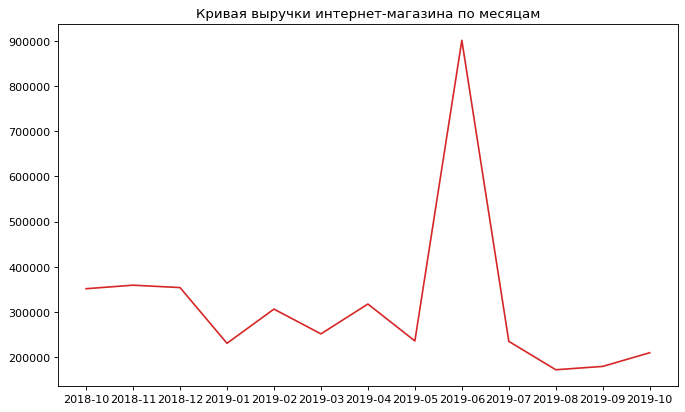

In [35]:
plt.figure(figsize=(10, 6), dpi= 80)
plt.plot('month_year', 'purchase_amount', data=revenue_per_month, color='tab:red')
plt.title('Кривая выручки интернет-магазина по месяцам')
plt.show()

**На первый взгляд продажи в интернет-магазине носят сезонный характер. Пик потребительской активности приходится на июнь. Изучим более подробно данные. Посмотрим подтверждается ли сезонный характер продаж увеличением количества заказов в этот период**

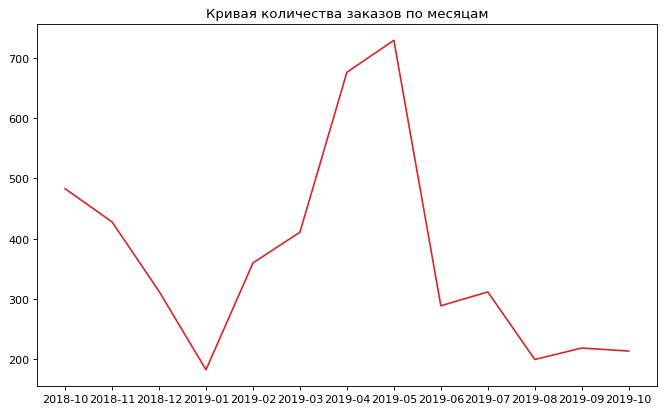

In [36]:
plt.figure(figsize=(10,6), dpi= 80)
plt.plot('month_year', 'order_id', data=revenue_per_month, color='tab:red')
plt.title('Кривая количества заказов по месяцам')  
plt.show()

**Судя по графику количество заказов стремительно растет с января по май и резко сокращается в июне. График также демонстрирует сезонность продаж, вместе с тем расходится с графиком выручки. Изучим выручку с каждого заказа**   

In [37]:
revenue_per_order = (
    filtred_data
    .groupby('order_id')
    .agg({'purchase_amount':'sum'})
    .sort_values(by='purchase_amount', ascending=False)
    .reset_index()
)
revenue_per_order.head(50)

,order_id,purchase_amount
0,71743,675000.0
1,71668,49432.0
2,69830,47385.0
3,69156,33680.0
4,69504,32718.0
5,68878,24370.0
6,68760,22056.0
7,70080,16536.0
8,71206,15680.0
9,71478,15300.0


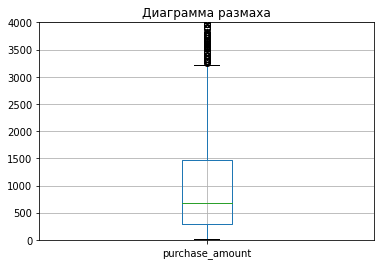

In [38]:
revenue_per_order.boxplot(column=['purchase_amount'])
plt.title('Диаграмма размаха')
plt.ylim(0,4000)
plt.show()

**Согласно диаграмме размаха заказы свыше 3300 являюся выбросами, которые могут существенно искажать реальную картину. Изучим содержание 10 самых дорогих заказов**

In [39]:
order = (revenue_per_order['order_id']
         .head(10)
         .tolist()
)
filtred_data.query('order_id ==@order')

,date,customer_id,order_id,product,quantity,price,purchase_amount,day_of_week,month_year,date_date,product_category
389,2018-10-26 13:00:00,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760,"Вешалка деревянная с расширенными плечиками и перекладиной 44,5х23 см см серый JAPANESE BLACK VALIANT JB-19708",8,262.0,2096.0,Friday,2018-10,2018-10-26,Хозяйственные товары
390,2018-10-26 13:00:00,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760,Вешалка для блузок 41 см черный Attribute AHM791,9,50.0,450.0,Friday,2018-10,2018-10-26,Хозяйственные товары
391,2018-10-26 13:00:00,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760,Вешалка с закругленными плечиками без перекладины с противоскользящим покрытием Valiant 226B10 черный,7,106.0,742.0,Friday,2018-10,2018-10-26,Хозяйственные товары
392,2018-10-26 13:00:00,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760,Гладильная доска Sarayli Tamara 125x42 см,1,3074.0,3074.0,Friday,2018-10,2018-10-26,Хозяйственные товары
393,2018-10-26 13:00:00,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760,Коврик влаговпитывающий ребристый 50х80 см Стандарт черный 5877,1,299.0,299.0,Friday,2018-10,2018-10-26,Хозяйственные товары
394,2018-10-26 13:00:00,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760,Коврик влаговпитывающий ребристый 60х90 см Стандарт зеленый 5884,1,412.0,412.0,Friday,2018-10,2018-10-26,Хозяйственные товары
395,2018-10-26 13:00:00,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760,Коврик придверный грязеулавливающий резиновый Finger 40х60,1,284.0,284.0,Friday,2018-10,2018-10-26,Хозяйственные товары
396,2018-10-26 13:00:00,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760,"Короб стеллажный с крышкой большой, 30*40*25 см, EXPEDITION VALIANT, EX-BOX-LM",1,674.0,674.0,Friday,2018-10,2018-10-26,Хозяйственные товары
397,2018-10-26 13:00:00,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760,"Короб стеллажный с крышкой малый, 28*30*16 см, EXPEDITION VALIANT, EX-BOX-LS",3,524.0,1572.0,Friday,2018-10,2018-10-26,Хозяйственные товары
398,2018-10-26 13:00:00,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760,"Коробка для хранения на молнии из синтетического волокна Hausmann, 35,5х20,5х13,5 см, зеленая, BB211-3",1,749.0,749.0,Friday,2018-10,2018-10-26,Хозяйственные товары


**В наборе данных заказы с аномально большим количеством товаров. Если 1000 заказанных вантузов не технический сбой выгрузки данных, то очень похоже на оптовый заказ. Даже если предположить, что эти заказы реальные, из набора данных их необходимо будет убрать, поскольку они единичные и не носят постоянного характера**

In [40]:
# Оставим в наборе данных только те заказы, сумма которых не превышает 3300
revenue_per_order = revenue_per_order.query('purchase_amount < 3300')
good_order = revenue_per_order['order_id'].tolist()

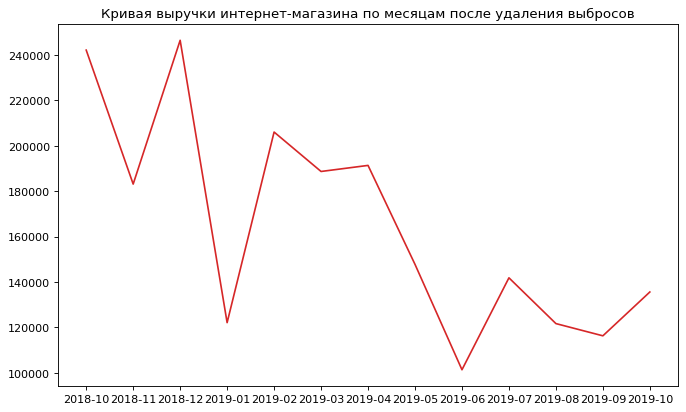

In [41]:
revenue_per_month = (
    filtred_data
    .query('order_id ==@good_order')
    .groupby('month_year')
    .agg({'purchase_amount':'sum', 'order_id':'count'})
    .reset_index()
)
plt.figure(figsize=(10,6), dpi= 80)
plt.plot('month_year', 'purchase_amount', data=revenue_per_month, color='tab:red')
plt.title('Кривая выручки интернет-магазина по месяцам после удаления выбросов')
plt.show()

**Убрав аномально большие заказы, можно оценить реальное положение дел интернет-магазина. Выручка на протяжении года с переменным успехом падала. Необходимо найти причины падения выручки, а вместе с тем и прибыли магазина.**

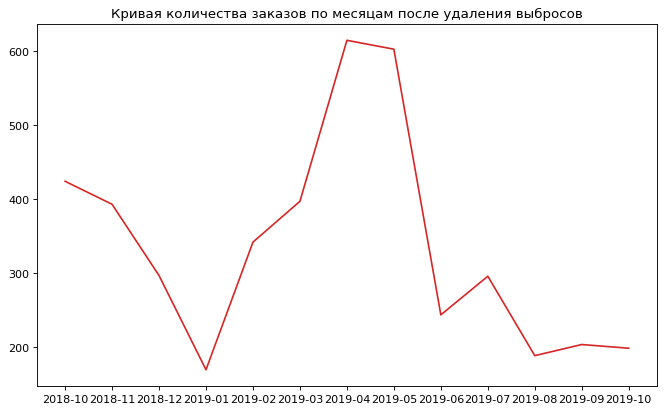

In [42]:
# Посмотрим изменилось ли количество заказов 
plt.figure(figsize=(10,6), dpi= 80)
plt.plot('month_year', 'order_id', data=revenue_per_month, color='tab:red')
plt.title('Кривая количества заказов по месяцам после удаления выбросов')
plt.show()

**График количества заказов остался неизменным. Необходимо выяснить с чем связано увеличение количества заказов в апреле-мае. Наименьшее количество заказов приходится на январь, в сравнении с аналогичным периодом предыдущего года количество заказов сократилось более чем в 2 раза. Предварительно можно связать падение выручки со сниженим количества заказов. Изучим динамику среднего чека за год**

In [43]:
revenue_per_month['avg_check'] = round(revenue_per_month['purchase_amount']/revenue_per_month['order_id'])
revenue_per_month.head()

,month_year,purchase_amount,order_id,avg_check
0,2018-10,242222.0,424,571.0
1,2018-11,183141.0,393,466.0
2,2018-12,246548.0,297,830.0
3,2019-01,122039.0,170,718.0
4,2019-02,206089.0,342,603.0


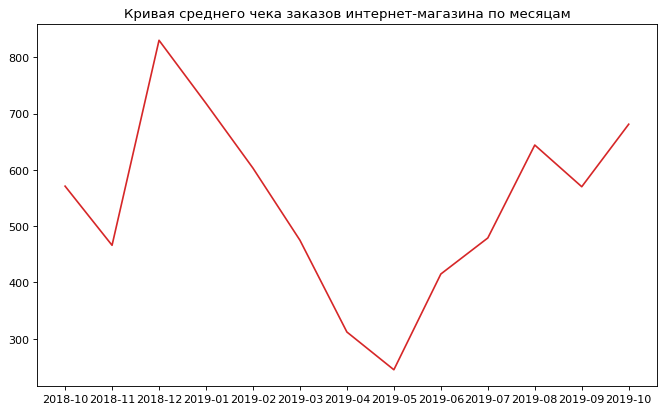

In [44]:
plt.figure(figsize=(10,6), dpi= 80)
plt.plot('month_year', 'avg_check', data=revenue_per_month, color='tab:red')
plt.title('Кривая среднего чека заказов интернет-магазина по месяцам')
plt.show()

**Средний чек падал до мая, а после начал стремительный рост. По отношению к анологичному периоду прошлого года средний чек вырос. Изучим распределение выручки за весь период наблюдения по товарным категориям**

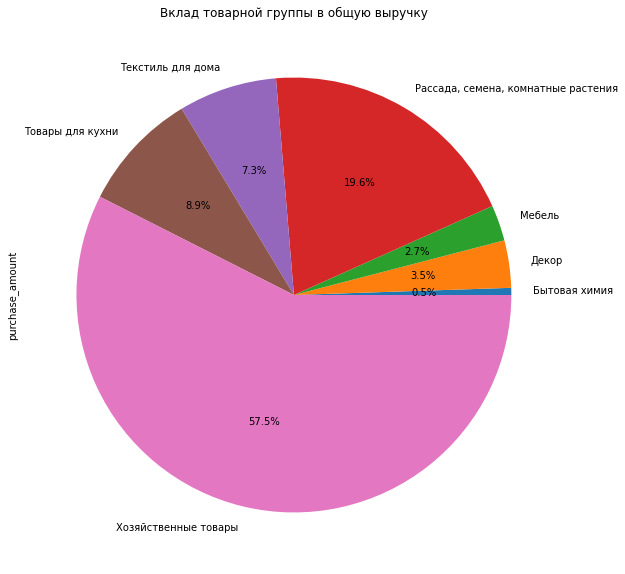

In [45]:
filtred_data.query('order_id ==@good_order').groupby('product_category').agg({'purchase_amount':'sum'}).plot.pie(y='purchase_amount', autopct='%.1f%%',figsize=(10, 10), legend=None)
plt.title('Вклад товарной группы в общую выручку') 
plt.show()

**Судя по круговой диаграмме основным источником прибыли интернет-магазина является продажа хозяйственных товаров. Также значительную долю выручки приносит продажа рассады, семян и комнатных растений. Изучим кривые продаж по категориям товаров**

In [46]:
sales_in_product_category = (
    filtred_data
    .query('order_id ==@good_order')
    .pivot_table(index ='month_year', columns = 'product_category', values='purchase_amount', aggfunc='sum')
)
sales_in_product_category

product_category,Бытовая химия,Декор,Мебель,"Рассада, семена, комнатные растения",Текстиль для дома,Товары для кухни,Хозяйственные товары
month_year,,,,,,,
2018-10,1089.0,8963.0,NaN,26917.0,20826.0,22998.0,161429.0
2018-11,1080.0,7467.0,NaN,18967.0,18931.0,23216.0,113480.0
2018-12,3430.0,4112.0,3230.0,25205.0,26284.0,31296.0,152991.0
2019-01,539.0,2805.0,2211.0,11984.0,11999.0,19543.0,72958.0
2019-02,1060.0,15206.0,3972.0,33372.0,14850.0,22768.0,114861.0
2019-03,1517.0,8484.0,5172.0,45255.0,15259.0,21566.0,91449.0
2019-04,479.0,6595.0,3414.0,78714.0,7286.0,4186.0,90702.0
2019-05,NaN,1606.0,2812.0,81721.0,4708.0,9663.0,47235.0
2019-06,164.0,3154.0,6298.0,23987.0,6796.0,3940.0,56929.0


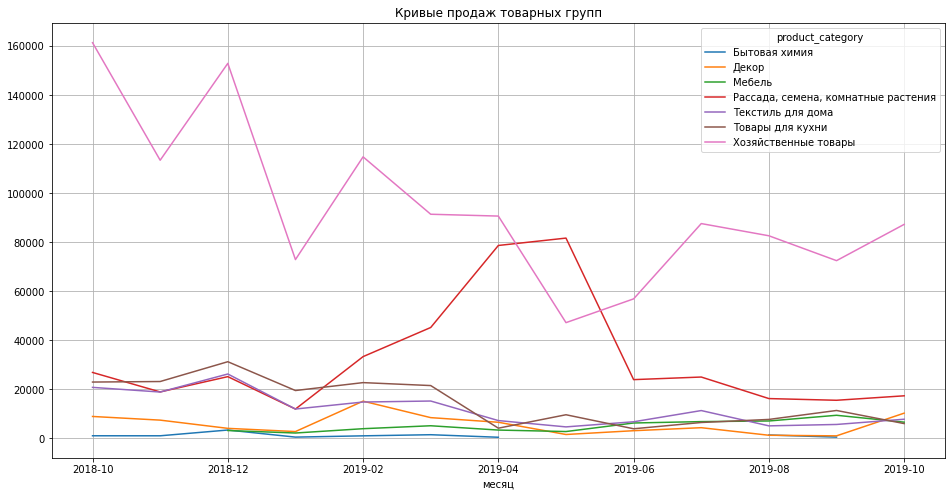

In [47]:

sales_in_product_category.plot(
    grid=True,   
    figsize=(16, 8))
plt.xlabel('месяц')  
plt.title('Кривые продаж товарных групп')  
plt.show()


**Согласно графику сезонный характер продаж носит категория товаров "Рассада, семена и комнатные растения". За исключением пика потребительской активности в категоии сезонных товаров (рассада) хозяйственные товары на протяжении всегод года приносят стабильно более высокую выручку магазину, чем другие категории. Отмечается снижение выручки в самой прибыльной категории  по отношению к аналогичному периоду прошлого года в 1.5 раза. Также изучим как выручка по категориям меняется на протяжении недели**

In [48]:
sales_in_product_category_day = (
    filtred_data
    .query('order_id ==@good_order')
    .pivot_table(index ='day_of_week', columns = 'product_category', values='purchase_amount', aggfunc='sum')
)
sales_in_product_category_day

product_category,Бытовая химия,Декор,Мебель,"Рассада, семена, комнатные растения",Текстиль для дома,Товары для кухни,Хозяйственные товары
day_of_week,,,,,,,
Monday,1631.0,9986.0,2061.0,80554.0,37363.0,30392.0,229407.0
Tuesday,3823.0,13564.0,3904.0,74076.0,23452.0,38065.0,215757.0
Wednesday,567.0,12605.0,11660.0,52236.0,16738.0,29176.0,184083.0
Thursday,1186.0,14321.0,16452.0,75847.0,25372.0,27113.0,177141.0
Friday,1363.0,8983.0,1500.0,55840.0,14647.0,26921.0,149186.0
Saturday,194.0,4156.0,7284.0,33202.0,17905.0,10462.0,134446.0
Sunday,2533.0,11823.0,14318.0,48627.0,21498.0,28765.0,142163.0


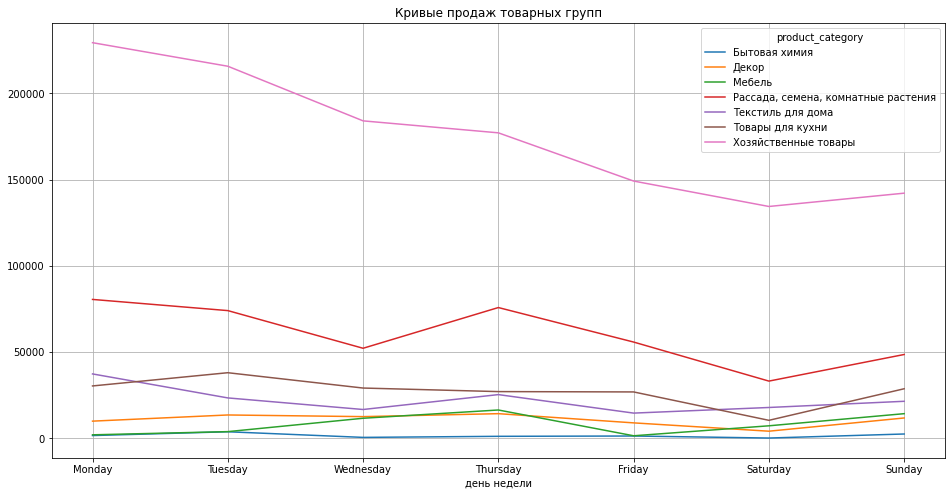

In [49]:
sales_in_product_category_day.plot(
    grid=True,   
    figsize=(16, 8))
plt.xlabel('день недели')  
plt.title('Кривые продаж товарных групп')  
plt.show()

**Все товарные категории демонстрируют снижение выручки в пятницу-субботу. Эта информация может пригодиться для маркетингового отдела в целях планирования запуска акций**

## Вывод по разделу

В результате исследовательского анализа данных удалось установить следующее:
- интернет-магазин предлагает товары в нескольких категориях: хозяйтсвенные товары, рассада, мебель, посуда, текстиль, декор, бытовая химия;
- спрос на товары категории "рассада, семена, комнатные растения" носит сезонный характер, пик потребительской активности приходиться на апрель-май (сопровождается общим увеличением количества заказов и выручки в данной категории);
- основную выручку на протяжении года приносит категория "хозяйственные товары", ее вклад в общую выручку за год около 60%.

На графиках фиксируется падение общей выручки по отношению к аналогичному периоду предыдушего года в 1.5. Исследование графиков количества заказов по месяцам и среднего чека позволяет сделать предположение, что падение выручки связано с уменьшением количества заказов. 

# Шаг 5. Сегментация пользователей
- выбор метода сегментирования 
- сегментация 
- описание сегментов пользователей (средний чек, минимальная/максимальная сумма заказа, количество заказов и пр., графики)

**Подготовим данные для сегментации. Оставим в наборе данных покупателей с заказами до 3300. Для определения количества сегментов воспользуемся моделью машинного обучения иерархическая кластеризации. Для этого подготовим основые признаки покупателей на основе их заказов: количество заказов, средний чек заказа, средняя стоимость позиции в заказе, среднее количество заказываемых товаров. Также для каждого покупателя определим лайфтайм в днях (период жизни с момента первого заказа до выгрузки данных), количество прошедших дней с момента последнего заказа, а также частоту заказов (количество заказов разделим на лайфтайм).**

In [50]:
# Оставим в наборе данных только пользователей с заказами до 3300 
filtered_data = filtred_data.query('order_id ==@good_order')

**Подготовим данные для сегментации пользователей**

In [51]:
# Сгруппируем данные по заказу и найдем среднюю стоимость позиции в заказе, сумму заказа, количество единиц товара в заказе

group_order = (
    filtered_data
    .pivot_table(index=['order_id',], values=['purchase_amount','quantity','price'], 
                 aggfunc={'purchase_amount':'sum', 'quantity':'sum', 'price':'mean'})
    .rename(columns={'purchase_amount':'sum', 'quantity':'total_quantity', 'price':'avg_price'})
)
display(group_order.head())

# Создадим словарь с заказами пользователей
dict_customers_order = filtered_data[['customer_id','order_id']].drop_duplicates().reset_index(drop=True)
display(dict_customers_order.head())

# Объединим данные заказов с пользователями
customers_profiles = (
    dict_customers_order
    .merge(group_order, how='left', on='order_id', right_index=False)
    .groupby('customer_id').agg({'order_id':'count', 'avg_price':'mean', 'sum':'mean', 'total_quantity':'mean'})
    .rename(columns={'order_id':'order','sum':'avg_check', 'total_quantity':'avg_quantity'})
    .reset_index()
)
customers_profiles.head()

,avg_price,sum,total_quantity
order_id,,,
12624,187.500000,375.0,2
13547,228.000000,684.0,3
14480,119.666667,359.0,3
14481,150.000000,600.0,4
14482,188.000000,376.0,2


,customer_id,order_id
0,ee47d746-6d2f-4d3c-9622-c31412542920,68477
1,375e0724-f033-4c76-b579-84969cf38ee2,68479
2,6644e5b4-9934-4863-9778-aaa125207701,68478
3,c971fb21-d54c-4134-938f-16b62ee86d3b,68480
4,161e1b98-45ba-4b4e-8236-e6e3e70f6f7c,68483


,customer_id,order,avg_price,avg_check,avg_quantity
0,000d6849-084e-4d9f-ac03-37174eaf60c4,1,138.75,555.0,4.0
1,001cee7f-0b29-4716-b202-0042213ab038,1,442.00,442.0,1.0
2,00299f34-5385-4d13-9aea-c80b81658e1b,1,457.00,914.0,2.0
3,002d4d3a-4a59-406b-86ec-c3314357e498,1,1649.00,1649.0,1.0
4,003bbd39-0000-41ff-b7f9-2ddaec152037,1,1162.00,2324.0,2.0


In [52]:
#filtered_data.query('customer_id == "c971fb21-d54c-4134-938f-16b62ee86d3b"')

In [53]:
# Найдем лайфтайм, количество дней с момента последнего заказа и добавим информацию в пользовательские профили
a = (
    filtered_data
    .groupby(['customer_id']).agg({'date':['min','max']})
    .droplevel(level=0, axis=1)
)
a['lifetime'] = ((datetime(2019, 11, 2,0,0)) - a['min']).dt.days
a['recency'] = ((datetime(2019, 11, 2,0,0))-a['max']).dt.days
a = a[['lifetime', 'recency']]
display(a.tail())
customers_profiles = customers_profiles.merge(a, how='left', on='customer_id', right_index=False)
customers_profiles['frequency'] = customers_profiles['order'] / customers_profiles['lifetime']
customers_profiles.head()

,lifetime,recency
customer_id,,
ff601403-b094-4b86-9ac6-264d725b9277,77,77
ffaeab76-3a8d-49ee-860f-17273b2fc8a2,2,2
ffb5976a-7a4d-460b-95c4-5ffaba31cb24,322,322
ffb80538-3fda-4351-8ea9-9d2bec58bb07,53,53
ffe82299-3f5b-4214-87fe-3d36ecccfac3,10,10


,customer_id,order,avg_price,avg_check,avg_quantity,lifetime,recency,frequency
0,000d6849-084e-4d9f-ac03-37174eaf60c4,1,138.75,555.0,4.0,16,16,0.062500
1,001cee7f-0b29-4716-b202-0042213ab038,1,442.00,442.0,1.0,258,258,0.003876
2,00299f34-5385-4d13-9aea-c80b81658e1b,1,457.00,914.0,2.0,18,18,0.055556
3,002d4d3a-4a59-406b-86ec-c3314357e498,1,1649.00,1649.0,1.0,278,278,0.003597
4,003bbd39-0000-41ff-b7f9-2ddaec152037,1,1162.00,2324.0,2.0,33,33,0.030303


[[-0.05809492 -0.66809493 -0.3775057  ... -1.716912   -1.70778672
   0.73933963]
 [-0.05809492 -0.21224189 -0.5310671  ...  0.46782575  0.47681094
  -0.19535482]
 [-0.05809492 -0.18969351  0.1103575  ... -1.69885632 -1.68973219
   0.62861825]
 ...
 [-0.05809492 -0.29191283 -0.60309148 ...  1.04560763  1.05455577
  -0.20763764]
 [-0.05809492  0.5874739   0.19189453 ... -1.38288185 -1.37377798
   0.04367511]
 [-0.05809492 -0.00930649 -0.3476088  ... -1.77107905 -1.76195029
   1.33723508]]


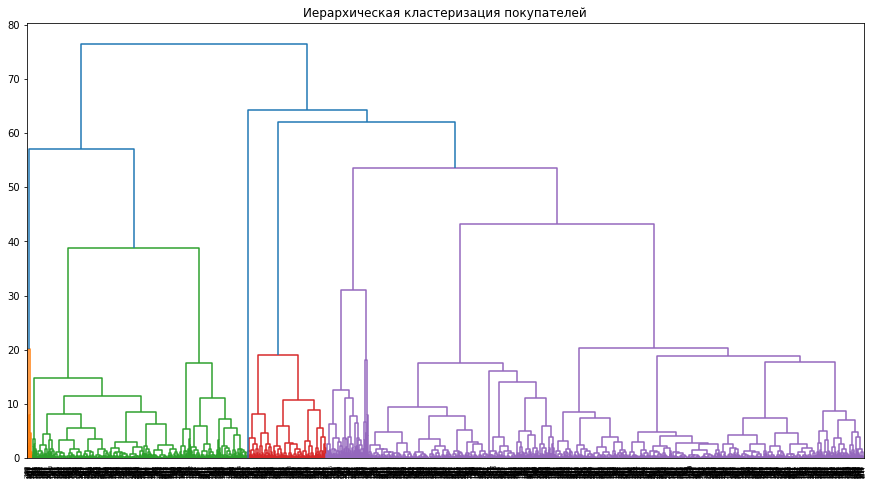

In [54]:
# Проведем иерархическую кластеризацию
scaler = StandardScaler()

# Стандартизируем и нормализируем данные
X_sc = scaler.fit_transform(customers_profiles.drop(columns=['customer_id'])) 
print(X_sc)

# Построим матрицу расстояний
linked = linkage(X_sc, method = 'ward')

# Визуализируем матрицу расстояний как дендрограмму
plt.figure(figsize=(15, 8))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация покупателей')
plt.show() 

**График предлагает разделить выборку на 4 кластера, именно столько центров агломерации выделяет алгоритм.**

In [55]:
# Зададим модель k_means с числом кластеров 4 
km = KMeans(n_clusters=4, random_state=0)

# Прогнозируем кластеры для наблюдений 
labels = km.fit_predict(X_sc)

# Сохраним метки кластера в поле датасета
customers_profiles['cluster_km'] = labels

# Посмотрим на статистику по средним значениям признаков по кластеру
clusters = customers_profiles.groupby(['cluster_km']).mean()
display(clusters)


,order,avg_price,avg_check,avg_quantity,lifetime,recency,frequency
cluster_km,,,,,,,
0,1.105811,353.489289,661.750873,4.356532,279.793582,278.796184,0.004146
1,1.109023,412.215362,596.814719,3.034879,87.728070,86.602757,0.036311
2,1.030928,1961.501718,2157.068729,1.280069,238.680412,238.553265,0.007300
3,117.000000,779.441880,988.794872,2.700855,396.000000,241.000000,0.295455


**Алгоритм разделили всех покупателей на 4 сегмента. В отдельный сегмент был выделен клиент, который оформили 117 заказов, посчитаем его как выброс и не будем описывать. Таким образом, всех покупателей можно разделить на 3 сегмента: 2 сегмента примерно с одинаковым средним чеком, разница сегментов в давности оформления заказов, и сегмент с высоким средним чеком.**

In [56]:
# Посмотрим на размер каждого сегмента
customers_profiles.groupby('cluster_km').agg({'customer_id':'count'})

,customer_id
cluster_km,
0,1153
1,798
2,291
3,1


In [57]:
# Изучим как распределены значения по признакам внутри каждого кластера
for cluster in customers_profiles['cluster_km'].unique():
    feature=customers_profiles.query('cluster_km==@cluster')
    display(feature.describe())

,order,avg_price,avg_check,avg_quantity,lifetime,recency,frequency,cluster_km
count,798.000000,798.000000,798.000000,798.000000,798.000000,798.000000,798.000000,798.0
mean,1.109023,412.215362,596.814719,3.034879,87.728070,86.602757,0.036311,1.0
std,0.631180,398.769095,497.527751,6.454292,51.613903,51.161479,0.101334,0.0
min,1.000000,14.000000,14.000000,1.000000,1.000000,1.000000,0.005525,1.0
25%,1.000000,127.000000,194.250000,1.000000,41.250000,41.000000,0.008065,1.0
50%,1.000000,224.500000,472.000000,1.000000,87.500000,87.000000,0.012658,1.0
75%,1.000000,600.000000,862.000000,2.000000,132.500000,130.000000,0.025641,1.0
max,16.000000,1949.000000,3290.000000,100.000000,221.000000,181.000000,1.000000,1.0


,order,avg_price,avg_check,avg_quantity,lifetime,recency,frequency,cluster_km
count,1153.000000,1153.000000,1153.000000,1153.000000,1153.000000,1153.000000,1153.000000,1153.0
mean,1.105811,353.489289,661.750873,4.356532,279.793582,278.796184,0.004146,0.0
std,0.922844,328.034328,546.649198,8.579716,62.766162,62.985387,0.002727,0.0
min,1.000000,14.000000,15.000000,1.000000,155.000000,155.000000,0.002519,0.0
25%,1.000000,109.333333,225.000000,1.000000,228.000000,226.000000,0.003040,0.0
50%,1.000000,194.000000,539.000000,1.000000,269.000000,269.000000,0.003788,0.0
75%,1.000000,562.000000,954.000000,4.000000,332.000000,332.000000,0.004608,0.0
max,30.000000,1349.000000,3006.000000,150.000000,397.000000,397.000000,0.075758,0.0


,order,avg_price,avg_check,avg_quantity,lifetime,recency,frequency,cluster_km
count,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.0
mean,1.030928,1961.501718,2157.068729,1.280069,238.680412,238.553265,0.007300,2.0
std,0.173420,601.407763,539.845876,1.226748,102.907948,102.953219,0.011672,0.0
min,1.000000,209.000000,1199.000000,1.000000,9.000000,9.000000,0.002525,2.0
25%,1.000000,1574.000000,1649.000000,1.000000,159.500000,159.500000,0.003145,2.0
50%,1.000000,1874.000000,1949.000000,1.000000,253.000000,253.000000,0.004000,2.0
75%,1.000000,2527.000000,2624.000000,1.000000,318.000000,318.000000,0.006689,2.0
max,2.000000,3299.000000,3299.000000,14.000000,396.000000,396.000000,0.111111,2.0


,order,avg_price,avg_check,avg_quantity,lifetime,recency,frequency,cluster_km
count,1.0,1.00000,1.000000,1.000000,1.0,1.0,1.000000,1.0
mean,117.0,779.44188,988.794872,2.700855,396.0,241.0,0.295455,3.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,117.0,779.44188,988.794872,2.700855,396.0,241.0,0.295455,3.0
25%,117.0,779.44188,988.794872,2.700855,396.0,241.0,0.295455,3.0
50%,117.0,779.44188,988.794872,2.700855,396.0,241.0,0.295455,3.0
75%,117.0,779.44188,988.794872,2.700855,396.0,241.0,0.295455,3.0
max,117.0,779.44188,988.794872,2.700855,396.0,241.0,0.295455,3.0


**На основании кластеризации можно выделить 3 группы покупателей. В первую группу попала значительная часть клиентов (1153), у которых в среднем лайфтайм больше 8 месцев, но которые оформили всего 1 заказ и больше не вернулись в интернет-магазин повторно. Средний чек составляет 660 (медиана 540). Вторая группа также значительная по количеству клиентов (798), в нее попали покупатели, которые делали заказы в течение последних трех месяцев. Средний чек 596 (медиана 472). Третья группа самая малочисленная - 291 покупатель, которые совершали покупки в среднем 8 месяцев назад (то есть также клиенты с длительным лайфтаймом), но средний чек этого сегмента занчительно выше двух других - 2157. Характерно, что все клиенты совершали разово покупки и больше не возвращались. У интернет-магазина проблемы с конвертаций покупателей в постоянные клиенты.**

In [58]:
# Подготовим списки с пользователями
customers_0 = customers_profiles.loc[customers_profiles['cluster_km'] == 0, 'customer_id'].tolist()
print(len(customers_0))
customers_1 = customers_profiles.loc[customers_profiles['cluster_km'] == 1, 'customer_id'].tolist()
print(len(customers_1))
customers_2 = customers_profiles.loc[customers_profiles['cluster_km'] == 2, 'customer_id'].tolist()
print(len(customers_2))
customers_3 = customers_profiles.loc[customers_profiles['cluster_km'] == 3, 'customer_id'].tolist()
print(len(customers_3))

1153
798
291
1


In [59]:
# Узнаем в какой временной период попали клиенты группы 1
print(filtered_data.query('customer_id ==@customers_0')['date'].min())
print(filtered_data.query('customer_id ==@customers_0')['date'].max())

2018-10-01 00:00:00
2019-05-30 07:00:00


In [60]:
# Узнаем в какой временной период попали клиенты группы 2
print(filtered_data.query('customer_id ==@customers_1')['date'].min())
print(filtered_data.query('customer_id ==@customers_1')['date'].max())

2019-03-25 11:00:00
2019-10-31 14:00:00


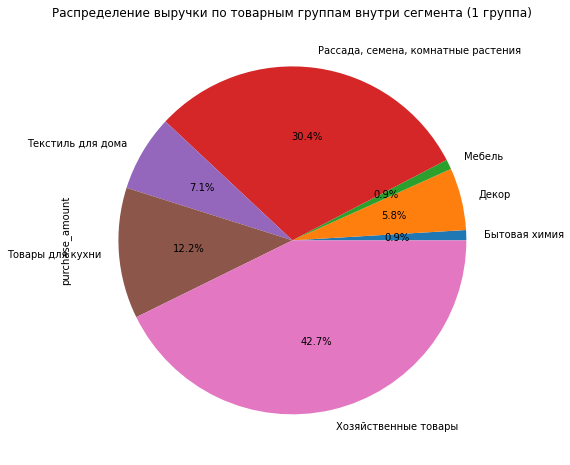

In [61]:
# Изучим какие товарные группы пользуются спросом в каждом сегменте
profiles_0 = (
    filtered_data
    .query('customer_id ==@customers_0')
    .groupby('product_category').agg({'purchase_amount':'sum'})
    .plot.pie(y='purchase_amount', autopct='%.1f%%',figsize=(8, 8), legend=None)
)
plt.title('Распределение выручки по товарным группам внутри сегмента (1 группа)') 

plt.show()

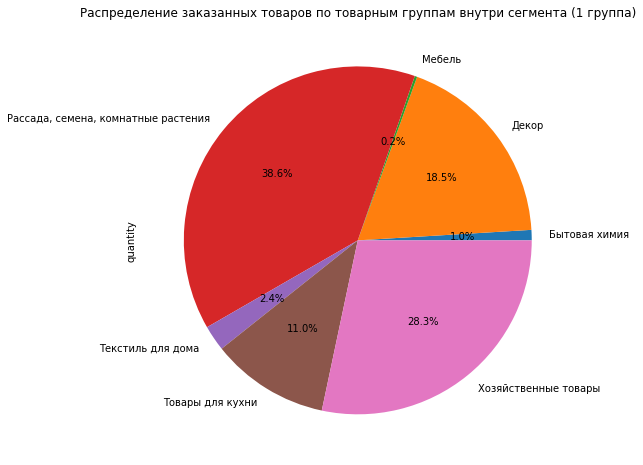

In [62]:
profiles_0= (
    filtered_data
    .query('customer_id ==@customers_0')
    .groupby('product_category').agg({'quantity':'sum'})
    .plot.pie(y='quantity', autopct='%.1f%%',figsize=(8, 8), legend=None)
)
plt.title('Распределение заказанных товаров по товарным группам внутри сегмента (1 группа)') 

plt.show()

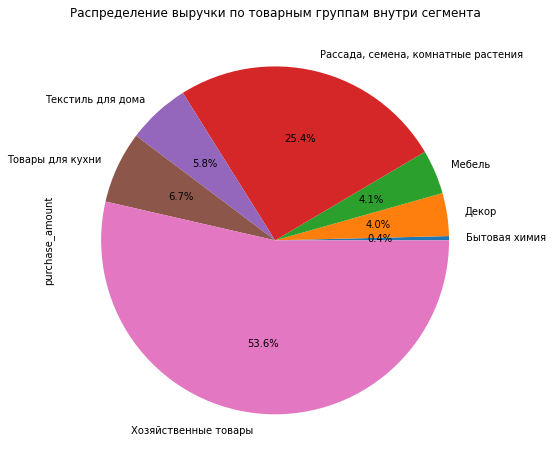

In [63]:
profiles_1 = (
    filtered_data
    .query('customer_id ==@customers_1')
    .groupby('product_category').agg({'purchase_amount':'sum'})
    .plot.pie(y='purchase_amount', autopct='%.1f%%',figsize=(8, 8), legend=None)
)
plt.title('Распределение выручки по товарным группам внутри сегмента') 

plt.show()

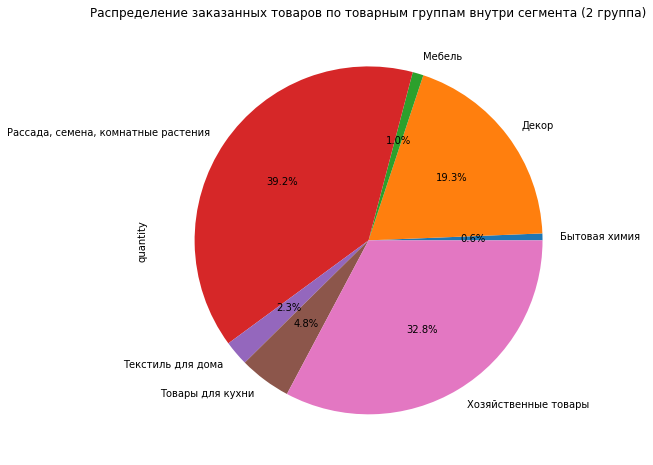

In [64]:
profiles_1= (
    filtered_data
    .query('customer_id ==@customers_1')
    .groupby('product_category').agg({'quantity':'sum'})
    .plot.pie(y='quantity', autopct='%.1f%%',figsize=(8, 8), legend=None)
)
plt.title('Распределение заказанных товаров по товарным группам внутри сегмента (2 группа)') 

plt.show()

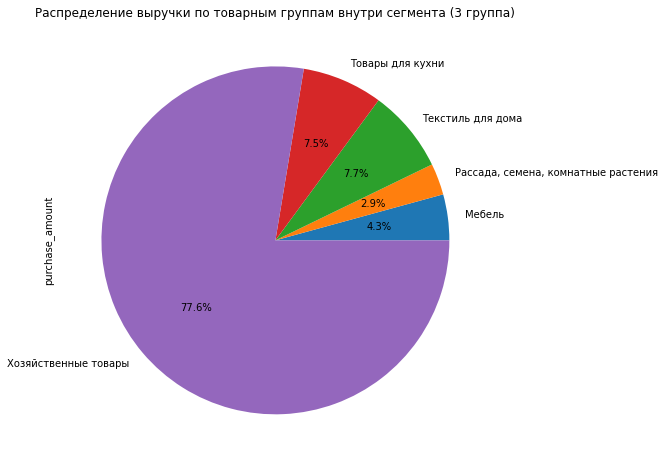

In [65]:
profiles_2 = (
    filtered_data
    .query('customer_id ==@customers_2')
    .groupby('product_category').agg({'purchase_amount':'sum'})
    .plot.pie(y='purchase_amount', autopct='%.1f%%',figsize=(8, 8), legend=None)
)
plt.title('Распределение выручки по товарным группам внутри сегмента (3 группа)') 

plt.show()

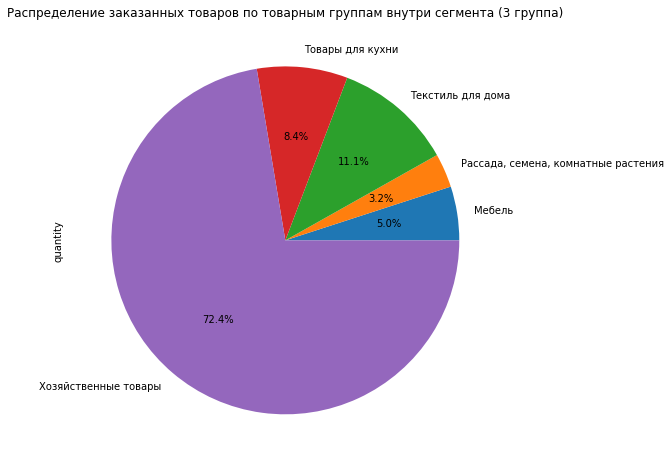

In [66]:
profiles_2 = (
    filtered_data
    .query('customer_id ==@customers_2')
    .groupby('product_category').agg({'quantity':'sum'})
    .plot.pie(y='quantity', autopct='%.1f%%',figsize=(8, 8), legend=None)
)
plt.title('Распределение заказанных товаров по товарным группам внутри сегмента (3 группа)') 

plt.show()

**Первые две группы очень схожи в своих предпочтениях: товаров покупают больше в категории "рассада, семена, комнатные растения", но по выручке получается, что хозяйственные товаров на большую сумму приобретают. Поскольку две большие группы составляют практически всех покупателей, их заказы отражают общую картину вклада каждой товарной группы в выручку. Довольно интересна группа покупателей с высоким средним чеком. Клиенты приобретают товар из категории "хозяйственные товары", то есть их мало интересует сезонный товар.** 

## Вывод по разделу

В результате сегментации покупателей было выделено 3 группы. 

 - 1 и 2 группа значительные по количеству клиентов - 1153 и 798 соответственно. Клиенты этих групп очень схожи в поведении: 1 заказ, преимущественно в корзину попадают товары из категорий: рассада, семена, комнатные растения, хозяйственные товары, декор, товары для кухни. Реже мебель и бытовая химия. У групп схожий средний чек 560-660. Отличительной характеристикой является время оформления заказа. В 1 группу попали клиенты давность заказа 6 месяцев и больше. Во 2 группу попали клиенты, которые относительно недавно (от 1 дня и до 3 месяцев) оформили заказ. 

 - В 3 группе оказались клиенты, которые приобретают товары преимущественно из категории хозяйственные товары. Также покупатели приобретают мебель. Товары из категории рассада, семена меньше всего представлены в из заказах. Средний чек таких заказов значительно выше 1 и 2 группы и составляет 2157. 

Все группы объединяет то, что клиенты, оформившие заказ, не возвращаются в магазин за новыми покупками. В среднем на каждого клиента приходится чуть бульше одного заказа. Данный факт свидетельсвует о наличии проблемы с конвертацией покупателей в постоянных клиентов.
 

# Шаг 6.Статистический анализ данных

Согласно графику выручка интернет-магазина постепенно снижалась. Узнаем не связано ли снижение выручки с ухудшением покупателей. На этапе сегментации пользовательских профилей выделили 2 группы со схожим средним чеком и количеством заказов. Количество в группах примерно одинаковое. Проверим существует ли статистически значимая разница в средних чеках. А также узнаем не связано ли различие в среднем чеке наличием в заказе более дорогих товаров.

**Н0: Средний чек в 1 и 2группах  одинаковый.**

**Н1: Средний чек в 1 и 2 группах  разный.**

In [67]:
customers_profiles.head()

,customer_id,order,avg_price,avg_check,avg_quantity,lifetime,recency,frequency,cluster_km
0,000d6849-084e-4d9f-ac03-37174eaf60c4,1,138.75,555.0,4.0,16,16,0.062500,1
1,001cee7f-0b29-4716-b202-0042213ab038,1,442.00,442.0,1.0,258,258,0.003876,0
2,00299f34-5385-4d13-9aea-c80b81658e1b,1,457.00,914.0,2.0,18,18,0.055556,1
3,002d4d3a-4a59-406b-86ec-c3314357e498,1,1649.00,1649.0,1.0,278,278,0.003597,2
4,003bbd39-0000-41ff-b7f9-2ddaec152037,1,1162.00,2324.0,2.0,33,33,0.030303,1


In [68]:
# Подготовим массивы
group_1 = customers_profiles.query('cluster_km == 0')['avg_check']
group_2 = customers_profiles.query('cluster_km == 1')['avg_check']

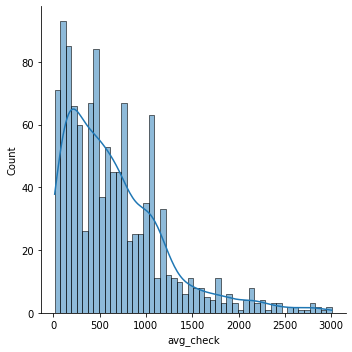

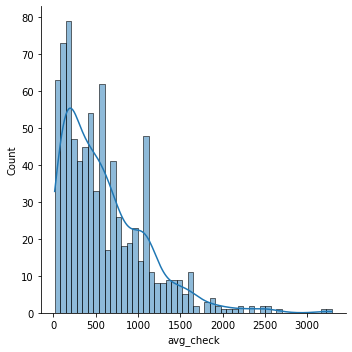

In [69]:
# Оценим характер распределения среднего выборки
sns.displot(x=group_1,
            kde=True,
            bins=50,
            fill=True)

sns.displot(x=group_2,
            kde=True,
            bins=50,
            fill=True)

На графиках отображены усеченные распределения. Скошены вправо. Так как  распределения средних показателей не симметрично, для проверки статистических гипотез будем применять t-test

In [70]:
#проверим гипотезы
alpha = .05 

results = st.ttest_ind(
    group_1, 
    group_2,
    equal_var = True 
)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.00752929658837641
Отвергаем нулевую гипотезу


In [71]:
print('разница между средними чеками в группах 1 и 2:',"{0:.3f}".format(group_1.mean() / group_2.mean() - 1))

разница между средними чеками в группах 1 и 2: 0.109


**Полученное значение p-value говорит о том, что вероятность получить такое различие между средними чеками случайно ниже заданного критерия значимости, поэтому следует, что разница между  средними чеками в 10% 1 и 2 групп статистически значима, чтобы принять нулевую гипотезу.**

**Н0: Средняя цена товаров в заказе клиентов  1 и 2 групп одинакова.**

**Н1: Средняя цена товаров в заказе клиентов  1 и 2 групп разная.**

In [72]:
# Подготовим массивы
group_1 = customers_profiles.query('cluster_km == 0')['avg_price']
group_2 = customers_profiles.query('cluster_km == 1')['avg_price']


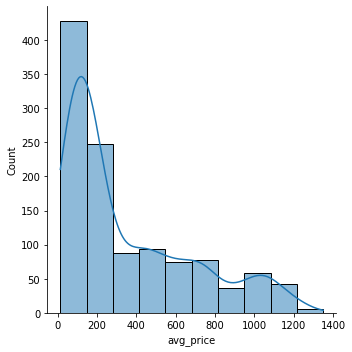

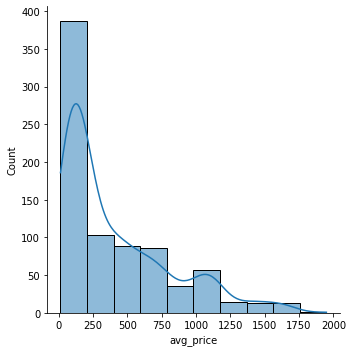

In [73]:
# Оценим характер распределения значений
sns.displot(x=group_1,
            kde=True,
            bins=10,
            fill=True)

sns.displot(x=group_2,
            kde=True,
            bins=10,
            fill=True)

In [74]:
#проверим гипотезы
alpha = .05 

results = st.ttest_ind(
    group_1, 
    group_2,
    equal_var = True  
)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.00038569257367057104
Отвергаем нулевую гипотезу


In [75]:
print('разница между средней ценой товаров в заказе клиентов групп 1 и 2:',"{0:.3f}".format(group_1.mean() / group_2.mean() - 1))

разница между средней ценой товаров в заказе клиентов групп 1 и 2: -0.142


**Средняя цена товаров в заказе группы 2 на 14% выше, чем средняя цена товаров в заказе 1 группы. Эта разница оказалась статистически значимой, чтобы принять нулевую гипотезу**

## Вывод по разделу

В результате проведнных статитстических тестов было установлено, что средний чек клиентов из группы 1  выше на 10%, что является статистически значимым различием, чтобы считать средние чеки в группах одинаковыми. 

Также оказалось, что в среднем стоимость товаров в корзине клиентов из группы 2 выше на 14 %, что также является статистическим значимым различием, чтобы считать эту разницу стандартным отклонением от одного среднего. Таким образом, можно предположить, что более высокий средний чек клиентов группы 1 связан с количеством товаров в корзине. Также, учитывая, что в среднем на одного покупателя приходится 1 заказ, выручка могла снизиться из-за снижения новых клиентов. 


,month_year,customer_id
0,2018-10,180
1,2018-11,178
2,2018-12,234
3,2019-01,150
4,2019-02,245
5,2019-03,232
6,2019-04,238
7,2019-05,167
8,2019-06,152
9,2019-07,186


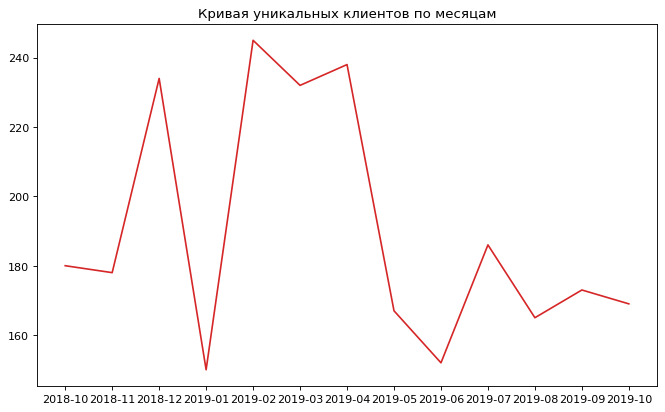

In [76]:
new_customers_per_day = (
    filtred_data
    .groupby('month_year').agg({'customer_id':'nunique'}).reset_index()
)
display(new_customers_per_day)
plt.figure(figsize=(10, 6), dpi= 80)
plt.plot('month_year', 'customer_id', data=new_customers_per_day, color='tab:red')
plt.title('Кривая уникальных клиентов по месяцам')
plt.show()

# Общий вывод  и рекомендации

В результате проведнного исследования было выявлено, что помесячная выручка интернет-магазина постепенно в течение года снижалась. Разница с анологичным периодом прошлого года составила около 1.5 %. 

Проведенный анализ клиентских профилей позволяет сделать вывод, что снижение выручки связано со следующими причинами:
- покупатели не конвертируются в постоянных клиентов;
- средний чек более ранних покупателей (в период с октября 2018 года по май 2019)  на 10 % выше, чем  у более поздних клиентов;
- количество новых покупателей по дням на сайте к концу исследуемого периода снизилось.

Изменить ситуацию возможно при системном подходе, который включает:
- согласно принципу Парето 20% усилий дает 80% результата, поэтому чтобы увеличить общую выручку необходимо конвертировать не менее 20% покупателей в постоянные клиенты, которые будут лояльны к предложениям магазина и будут совершать покупки с определенной частотой. В настоящий момент есть сегменты с высоким средним чеком и не очень. Необходимо, чтобы постоянные клиенты появились в каждом сегменте; 
- для увеличения среднего чека необходимо делать рассылку пользователям с персональными предложениями. Также, учитывая, что в пятницу-субботу фиксируется снижение выручки, запустить дополнительные акции стимулирующие покупки (например, приобрести 3 товар по специальной цене);
- в целях привлечения новых покупателей -запустить или пересмотреть существующую маркетинговую кампанию.

В результате сегментации были получены группы схожих по поведению покупателей. Сегментация клиентов позволяет направлять клиентам персонализированные предложения. Однако, не имея постоянных клиентов, сложно основываться лишь на 1 заказе, чтобы предложить максимально подходящий товар. 

Вместе с тем, уже сейчас зная, что есть два сегмента пользователей с разными средними чеками, можно настроить рассылку с новинками и специальными предложениями в приоритетной товарной категории и определенного ценового сегмента. 

"Разбудить" спящих клиентов возможно напоминанием о совершенной покупке и промокодом для нового заказа. 
